# Finding Critical Points with TensorFlow
## Part 3 - Visualizing Curvature Information at the End of SGD Training

This section is under construction.

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style='white')
%matplotlib inline

from collections import namedtuple

import crit_finder

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
Curvature = namedtuple("Curvature",
                       ["hessian", "eigenvalues", "eigenvectors"])

In [113]:
def compute_spectra(num_runs, mnist, hyperparameters, training_parameters, hessian_calc_batch_size=10000):
    
    initial_eigvals = []
    final_eigvals = []
    
    network = crit_finder.make_neural_network(hyperparameters)    
    
    for run_idx in range(num_runs):
        initial_parameters = get_initial_parameters(network)
        
        final_parameters = train_network(network, mnist, initial_parameters, training_parameters)
        
        initial_curvature = get_hessian_and_eigs(network, mnist, initial_parameters, hessian_calc_batch_size)

        final_curvature = get_hessian_and_eigs(network, mnist, final_parameters, hessian_calc_batch_size)
        
        initial_eigvals.append(initial_curvature.eigenvalues)
        final_eigvals.append(final_curvature.eigenvalues)
        
    return initial_eigvals, final_eigvals

def train_network(network, mnist, initial_parameters, training_parameters):
    graph = network.graph
    graph_dict = network.graph_dictionary
    hyperparameter_dictionary = network.hyperparameter_dictionary
    
    with tf.Session(graph=graph) as sess:
        
        # collect tensorflow handles from graph_dict
        input = graph_dict["input"]
        labels = graph_dict["labels"]
        parameters_placeholder = graph_dict["parameters_placeholder"]
        current_parameters = graph_dict["parameters"]
        step_gradient_descent = graph_dict["step_gradient_descent"]
        accuracy = graph_dict["accuracy"]
        cost = graph_dict["cost"]
        gradient_op = graph_dict["gradients"]
        
        # collect training parameters from training_parameters
        num_batches = training_parameters["num_batches"]
        print_every = training_parameters["print_every"]
        tracking_batch_size = training_parameters["tracking_batch_size"]
        gradient_descent_batch_size = training_parameters["gradient_descent_batch_size"]

        initializer_feed_dict = {parameters_placeholder: initial_parameters}
        tf.global_variables_initializer().run(initializer_feed_dict)    

        for batch_idx in range(num_batches):

            #report values before taking any steps
            if (batch_idx+1 == 1): 

                batch_inputs, batch_labels = mnist.train.next_batch(tracking_batch_size)
                train_feed_dict = {input: batch_inputs,
                           labels: batch_labels}

                current_cost = sess.run(cost, feed_dict=train_feed_dict)
                init_gradients = sess.run(gradient_op, feed_dict=train_feed_dict)
                gradient_norm = np.linalg.norm(init_gradients)

                print("init values")
                print("\tcost: {0:.2f}".format(current_cost))
                print("\tgrad_norm: {0:.10f}".format(gradient_norm))

            batch_inputs, batch_labels = mnist.train.next_batch(gradient_descent_batch_size)
            train_feed_dict = {input: batch_inputs,
                           labels: batch_labels}
            
            sess.run(step_gradient_descent, feed_dict=train_feed_dict)
            
            #report values after 1st step and intermittently
            if (batch_idx+1 == 1) or ((batch_idx+1)%print_every == 0): 
            
                batch_inputs, batch_labels = mnist.train.next_batch(tracking_batch_size)
                train_feed_dict = {input: batch_inputs,
                           labels: batch_labels}

                current_cost = sess.run(cost, feed_dict=train_feed_dict)

                gradients = sess.run(gradient_op, feed_dict=train_feed_dict)
                gradient_norm = gradient_norm = np.linalg.norm(gradients)

                print("grad step: {0}".format(batch_idx+1))
                print("\tcost: {0:.2f}".format(current_cost))
                print("\tgrad_norm: {0:.10f}".format(gradient_norm))

        final_parameters = sess.run(current_parameters)
            
    return final_parameters

def get_hessian_and_eigs(network, mnist, parameter_values, hessian_calc_batch_size=50000):
    graph = network.graph
    graph_dict = network.graph_dictionary
    
    with tf.Session(graph=graph) as sess:

        input = graph_dict["input"]
        labels = graph_dict["labels"]

        initial_parameters = graph_dict["parameters_placeholder"]

        hessian = graph_dict["hessian"]
        eigenvalues = graph_dict["eigenvalues"]
        eigenvectors = graph_dict["eigenvectors"]
        
        initializer_feed_dict = {initial_parameters: parameter_values}
        tf.global_variables_initializer().run(initializer_feed_dict)

        batch_inputs, batch_labels = mnist.train.next_batch(hessian_calc_batch_size)

        hessian_calc_feed_dict = {input: batch_inputs,
                           labels: batch_labels}

        hessian, eigenvalues, eigenvectors =  sess.run([hessian, eigenvalues, eigenvectors],
                                                       hessian_calc_feed_dict)
    
    return Curvature(hessian, eigenvalues, eigenvectors)

def spectrum_plot(initial_eigvals_list, final_eigvals_list, plotting_kws, tick_kws, label_kws, eps=0,
                  xlims=None, ylims=None):

    f = plt.figure(figsize=(12,12))

    for initial_eigvals, final_eigvals in zip(initial_eigvals_list, final_eigvals_list):
        sns.distplot(initial_eigvals[np.abs(initial_eigvals)>eps],
                     color=sns.xkcd_rgb['denim blue'], label='initial', **plotting_kws);
        sns.distplot(final_eigvals[np.abs(final_eigvals)>eps],
                     color=sns.xkcd_rgb['pale red'], label='final', **plotting_kws);
        
    ax = plt.gca()
    ax.set_yscale('log')
    
    if ylims is not None:
        ax.set_ylim(ylims)
        
    if xlims is not None:
        ax.set_xlim(xlims)
        
    #ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=10, integer=True))
#     ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=10, integer=False))
    
    #ax.set_xticklabels([int(tick) for tick in ax.get_xticks()], tick_kws)
    ax.set_xticklabels([round(tick,5) for tick in ax.get_xticks()], tick_kws)
    ax.set_yticklabels([int(tick) for tick in ax.get_yticks()], tick_kws)
    
    ax.set_xlabel(r"$\lambda$", **label_kws)
    ax.set_ylabel(r"$\rho(\lambda)$", **label_kws)
    
    ax.legend(**label_kws);

def get_initial_parameters(network):
    
    graph = network.graph
    graph_dict = network.graph_dictionary
    hyperparameter_dictionary = network.hyperparameter_dictionary
    num_parameters = hyperparameter_dictionary["num_parameters"]
    total_weights = hyperparameter_dictionary["total_weights"]
    total_biases = hyperparameter_dictionary["total_biases"]
    
    initialized_parameters = parameters_from_totals(total_weights, total_biases)
    
    return initialized_parameters

def parameters_from_totals(total_weights, total_biases):
    
    initialized_parameters = np.hstack([0.1*np.random.standard_normal(size=total_weights),
                                  [0.1]*total_biases]).astype(np.float32)
    
    return initialized_parameters

In [82]:
hyperparameters = {"layer_sizes":[10],
                    "nonlinearity":tf.nn.relu,
                    "input_size":784,
                    "output_size":10,
                    "learning_rate":0.01,
                    "newton_rate":1e-3,
                    "grad_norm_learning_rate":1e-6,
                    "minimum_eigenvalue_magnitude":1e-1,
                    "inverse_method": "pseudo"}

training_parameters = {"num_batches" : 10000,
                       "print_every" : 1000,
                       "tracking_batch_size" : 1000,
                       "gradient_descent_batch_size" :500,
                      }

initial_eigvals, final_eigvals = compute_spectra(10, mnist, hyperparameters,
                                                 training_parameters, hessian_calc_batch_size=10000)

init values
	cost: 2.32
	grad_norm: 0.2836883664
grad step: 1
	cost: 2.32
	grad_norm: 0.3153574765
grad step: 1000
	cost: 0.90
	grad_norm: 0.3271615505
grad step: 2000
	cost: 0.54
	grad_norm: 0.2524732053
grad step: 3000
	cost: 0.44
	grad_norm: 0.2324231714


KeyboardInterrupt: 

In [84]:
def normalize_eigvals(initial_eigvals_list, final_eigvals_list):
    normalized_initial_eigvals_list = []
    normalized_final_eigvals_list = []
    
    
    for initial_eigvals, final_eigvals in zip(initial_eigvals_list, final_eigvals_list):
        maximum = np.max([np.max(initial_eigvals), np.max(final_eigvals)])
        
        normalized_initial_eigvals = np.divide(initial_eigvals, maximum)
        normalized_final_eigvals = np.divide(final_eigvals, maximum)
        
        normalized_initial_eigvals_list.append(normalized_initial_eigvals)
        normalized_final_eigvals_list.append(normalized_final_eigvals)
    
    return normalized_initial_eigvals_list, normalized_final_eigvals_list

In [85]:
initial_eigvals = np.load("initial_eigvals_20180208.npz")
initial_eigvals = [initial_eigvals[key] for key in initial_eigvals.keys()]

final_eigvals = np.load("final_eigvals_20180208.npz")
final_eigvals = [final_eigvals[key] for key in final_eigvals.keys()]

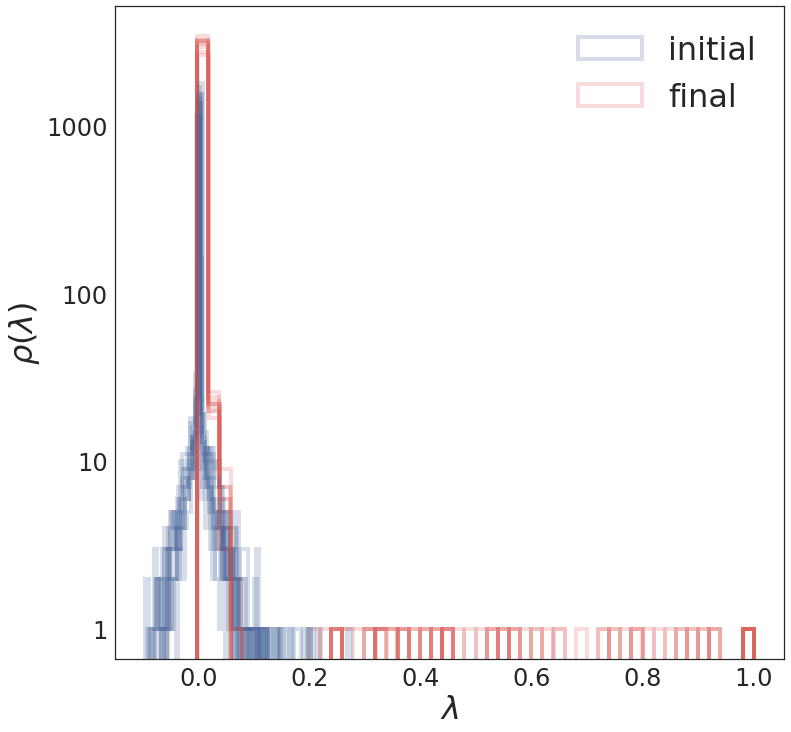

In [116]:
# bins = np.hstack([np.linspace(-0.1, -0.005, num=15),
#                  np.linspace(-0.005,0,50),
#                  np.linspace(1/20,1,20)])

bins=50

plotting_kws = {'bins':bins, 'kde':False, 'rug':False,
                'hist_kws':{'histtype':'step', 'alpha':0.2, 'linewidth':4}}

font_kws = {'fontsize': 24,}
tick_kws = {'fontsize': 24}
label_kws = {'fontsize': 32}

normalized_initial_eigvals, normalized_final_eigvals = normalize_eigvals(initial_eigvals, final_eigvals)

spectrum_plot(normalized_initial_eigvals, normalized_final_eigvals,
              plotting_kws, tick_kws, label_kws, eps=1e-5,
#               xlims=[-0.05, 0.05],
              ylims=None)

f = plt.gcf()

In [117]:
f.savefig("eigspectrum_log.pdf")

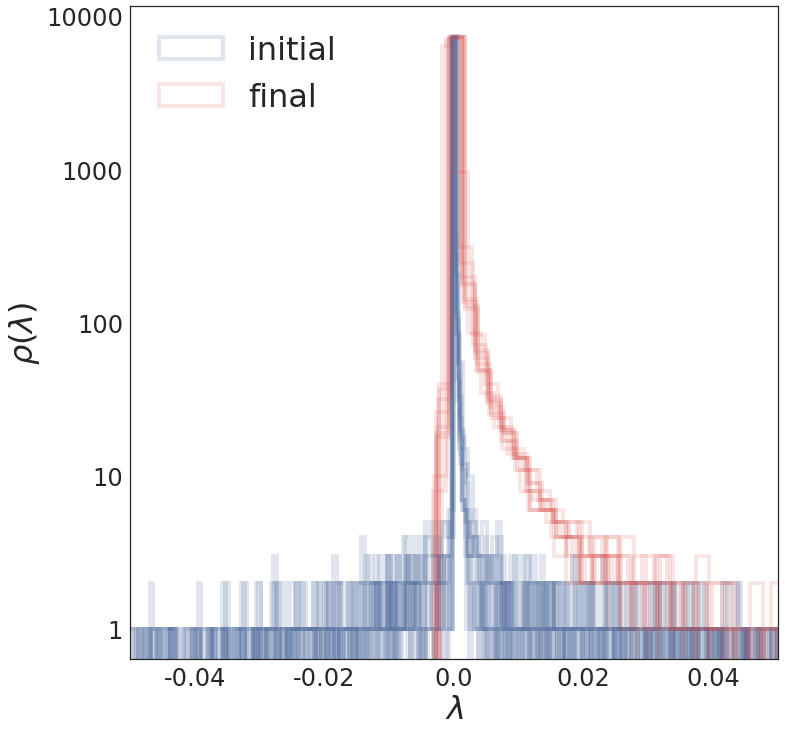

In [120]:
# bins = np.hstack([np.linspace(-0.1, -0.005, num=15),
#                  np.linspace(-0.005,0,50),
#                  np.linspace(1/20,1,20)])

bins=500

plotting_kws = {'bins':bins, 'kde':False, 'rug':False,
                'hist_kws':{'histtype':'step', 'alpha':0.15, 'linewidth':4}}

font_kws = {'fontsize': 24,}
tick_kws = {'fontsize': 24}
label_kws = {'fontsize': 32}

normalized_initial_eigvals, normalized_final_eigvals = normalize_eigvals(initial_eigvals, final_eigvals)

spectrum_plot(normalized_initial_eigvals, normalized_final_eigvals,
              plotting_kws, tick_kws, label_kws, eps=1e-50,
              xlims=[-0.05, 0.05],
              ylims=None)

f = plt.gcf()
f.subplots_adjust(left=0.15)